In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn # For nice looking plots.

import numpy as np
import scipy as sp
import scipy.io

import os
import copy
import time
import datetime

import tensorflow as tf

import sklearn
import sklearn.model_selection
import sklearn.ensemble
import sklearn.preprocessing

np.set_printoptions(precision=2, suppress=True, linewidth=140)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load the training and test data
sarcos_inv = scipy.io.loadmat('../data/sarcos_inv.mat')['sarcos_inv']
sarcos_inv_test = scipy.io.loadmat('../data/sarcos_inv_test.mat')['sarcos_inv_test']

def split_data(data, timesteps=1):
    X, Y = np.split(data, [21], axis=1)
    
    if timesteps == 1:
        return X, Y
    
    Xres = np.zeros((X.shape[0] - timesteps + 1, 21 * timesteps))
    Yres = Y[timesteps - 1:]
    
    for i in xrange(X.shape[0] - timesteps + 1):
        Xres[i] = np.reshape(X[i:i+timesteps], -1)
    
    return Xres, Yres


# Train random forest over many history steps

In [8]:
# Training with different tree depth

total_params = []

for history_steps in [1, 3]:
    params = []
    for n_estimators in [5, 10, 15, 20]:
        for max_depth in [5, 10, 15, 20, 25, 30]:
            params.append({
                'model': {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'n_jobs': 7
                },
                'history_steps': history_steps
            })

    nfold = 10
    kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

    # Model orders to be tested
    RSSts = np.zeros((len(params), nfold))

    X0, y0 = split_data(sarcos_inv, history_steps)
    
    for isplit, Ind in enumerate(kf.split(X0)):
        print('kfold split: %d' % (isplit))

        Itr, Its = Ind

        xtr = X0[Itr]
        ytr = y0[Itr]
        xts = X0[Its]
        yts = y0[Its]

        for it, param in enumerate(params):
            model = sklearn.ensemble.RandomForestRegressor(**param['model'])
            model.fit(xtr, ytr)

            yhat = model.predict(xts)
            RSSts[it, isplit] = np.mean((yts - yhat)**2)

    # Compute the l2 mean and normalized std right here.
    for i, p in enumerate(params):
        p['l2_mean'] = np.mean(RSSts, axis=1)[i]
        p['l2_std'] = np.std(RSSts, axis=1)[i] / np.sqrt(nfold - 1)
        
    total_params += params
            
params = total_params

kfold split: 0
kfold split: 1
kfold split: 2
kfold split: 3
kfold split: 4
kfold split: 5
kfold split: 6
kfold split: 7
kfold split: 8
kfold split: 9
kfold split: 0
kfold split: 1
kfold split: 2
kfold split: 3
kfold split: 4
kfold split: 5
kfold split: 6
kfold split: 7
kfold split: 8
kfold split: 9


In [11]:
np.savez_compressed('rfr_kfold_result.npz', params=params)

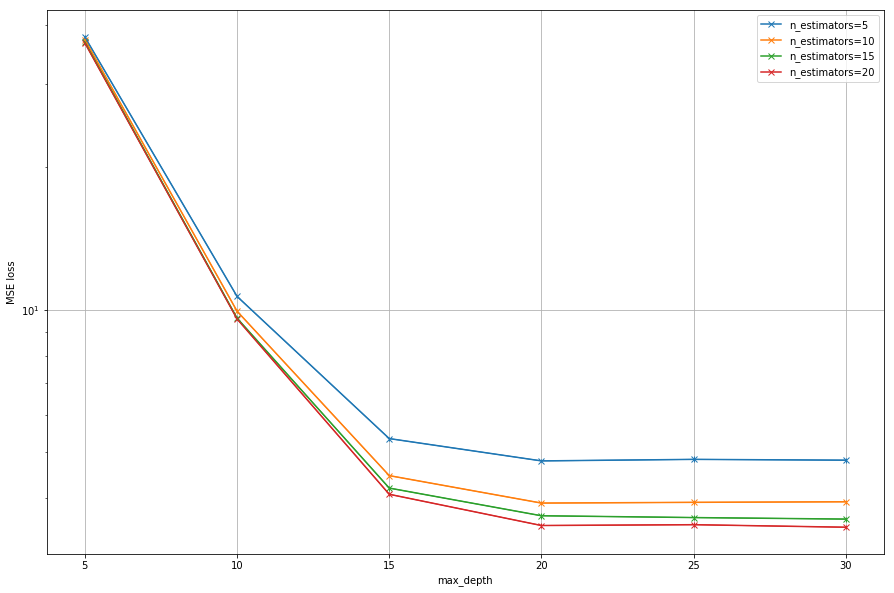

Min loss:
{'history_steps': 1, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 30}, 'l2_std': 0.03293898981310702, 'l2_mean': 3.476671701511296}

{'history_steps': 1, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 20}, 'l2_std': 0.04380312562012242, 'l2_mean': 3.505745083556394}
{'history_steps': 1, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 30}, 'l2_std': 0.03293898981310702, 'l2_mean': 3.476671701511296}


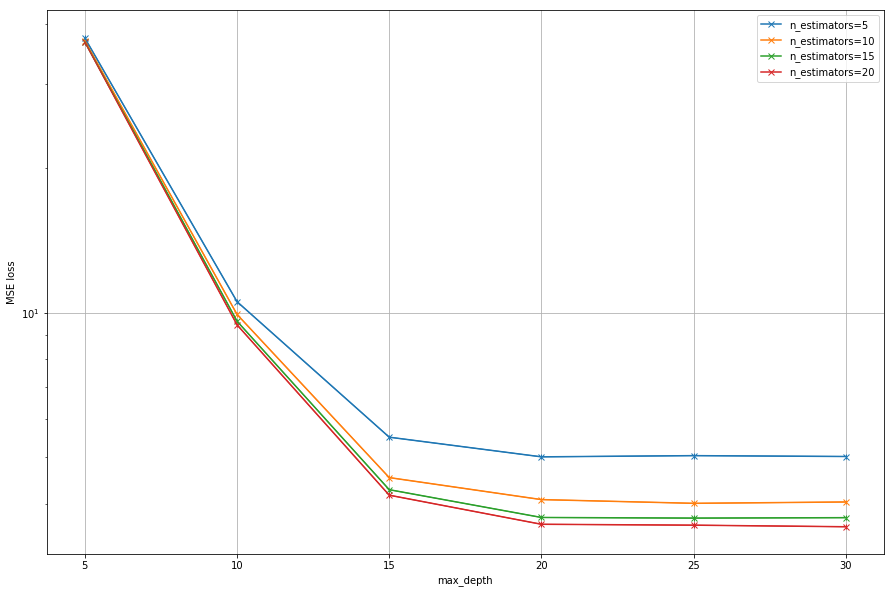

Min loss:
{'history_steps': 3, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 30}, 'l2_std': 0.041767808720152504, 'l2_mean': 3.5843275890256985}

{'history_steps': 3, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 25}, 'l2_std': 0.0503136238948671, 'l2_mean': 3.6114524948097335}
{'history_steps': 3, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 30}, 'l2_std': 0.041767808720152504, 'l2_mean': 3.5843275890256985}


In [10]:
def plot_params(params):    
    fig, axes = plt.subplots(1, 1, figsize=(15, 10))
    
    for i, n_estimators in enumerate(np.unique([p['model']['n_estimators'] for p in params])):
        ax = axes

        pars = [p for p in params if p['model']['n_estimators'] == n_estimators]
        x = [p['model']['max_depth'] for p in pars]
        y = [p['l2_mean'] for p in pars]
        yerr = [p['l2_std'] for p in pars]

        ax.set_yscale("log", nonposy='clip')

        p = ax.plot(x, y, 'x-', label="n_estimators=%d" % (n_estimators))
        ax.errorbar(x, y ,yerr=yerr, linewidth=1, color=p[0].get_color())

    plt.xlabel('max_depth')
    plt.ylabel('MSE loss')
    plt.grid()
    plt.legend()
    plt.show()


    l2_mean = [p['l2_mean'] for p in params]
    l2_std = [p['l2_std'] for p in params]
    min_idx = np.argmin(l2_mean)

    print 'Min loss:'
    print params[min_idx]
    print ''

    param_stdrule = [p for p in params if p['l2_mean'] < params[min_idx]['l2_mean'] + params[min_idx]['l2_std']]
    for p in param_stdrule:
        print p

for history_steps in np.unique([p['history_steps'] for p in params]):
    plot_params([p for p in params if p['history_steps'] == history_steps])

# Validation

In [32]:
best_params = [
    {
        'history_steps': 1,
        'model': {
            'n_estimators': 20, 'n_jobs': 7, 'max_depth': 20
        },
    }, {
        'history_steps': 3,
        'model': {
            'n_estimators': 20, 'n_jobs': 7, 'max_depth': 25
        },
    }
]

for param in best_params:
    xtr, ytr = split_data(sarcos_inv, param['history_steps'])
    xts, yts = split_data(sarcos_inv_test, param['history_steps'])
    
    model = sklearn.ensemble.RandomForestRegressor(**param['model'])
    model.fit(xtr, ytr)

    yhat = model.predict(xtr)
    MSE_tr = np.mean((ytr - yhat)**2)
    
    yhat = model.predict(xts)
    MSE_ts = np.mean((yts - yhat)**2)
    
    print 'Params:', param
    print 'MSE train:', MSE_tr
    print 'MSE test: ', MSE_ts
    print ''

Params: {'history_steps': 1, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 20}}
MSE train: 0.6086837614727219
MSE test:  0.6418024578797926

Params: {'history_steps': 3, 'model': {'n_estimators': 20, 'n_jobs': 7, 'max_depth': 25}}
MSE train: 0.5838223610370902
MSE test:  17.814128855010146

